In [22]:
from arch import arch_model

import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
        plt.show()

In [33]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j), trend='t').fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# 0. Import series

In [73]:
path = 'C:/Users/Igor/Learning/Machine Learning/Netology/3. TimeSeries/Series/monthly-boston-armed-robberies-j.csv'
series = pd.read_csv(path).iloc[:, 1]

# 1. Look at the series

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


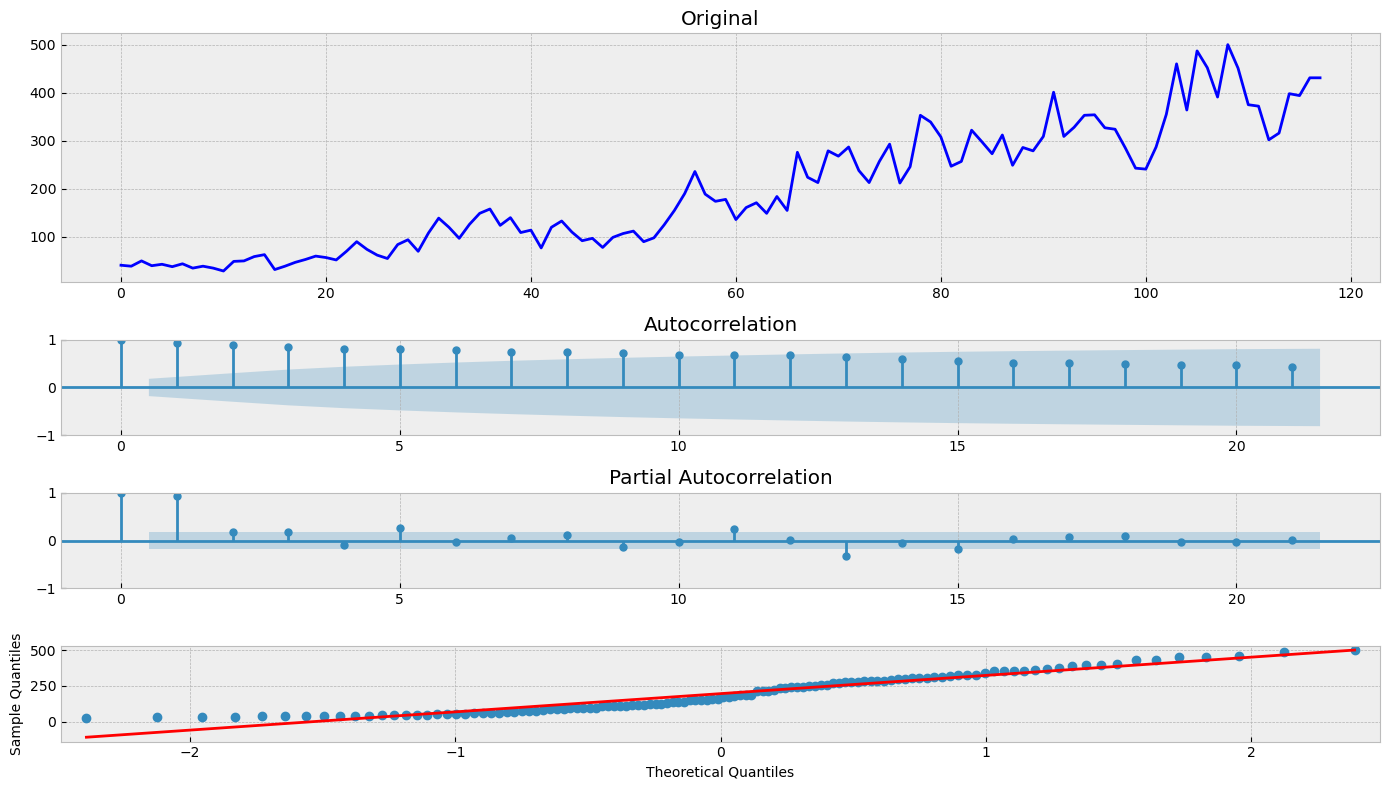

In [74]:
tsplot(series)

# 2. Find best order of coefficients and check residuals

In [75]:
aic, order, model = _get_best_model(series)

aic: 1179.10954 | order: (3, 1, 3)


Results of Dickey-Fuller Test:
Test Statistic                  -1.679526
p-value                          0.441691
#Lags Used                      12.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


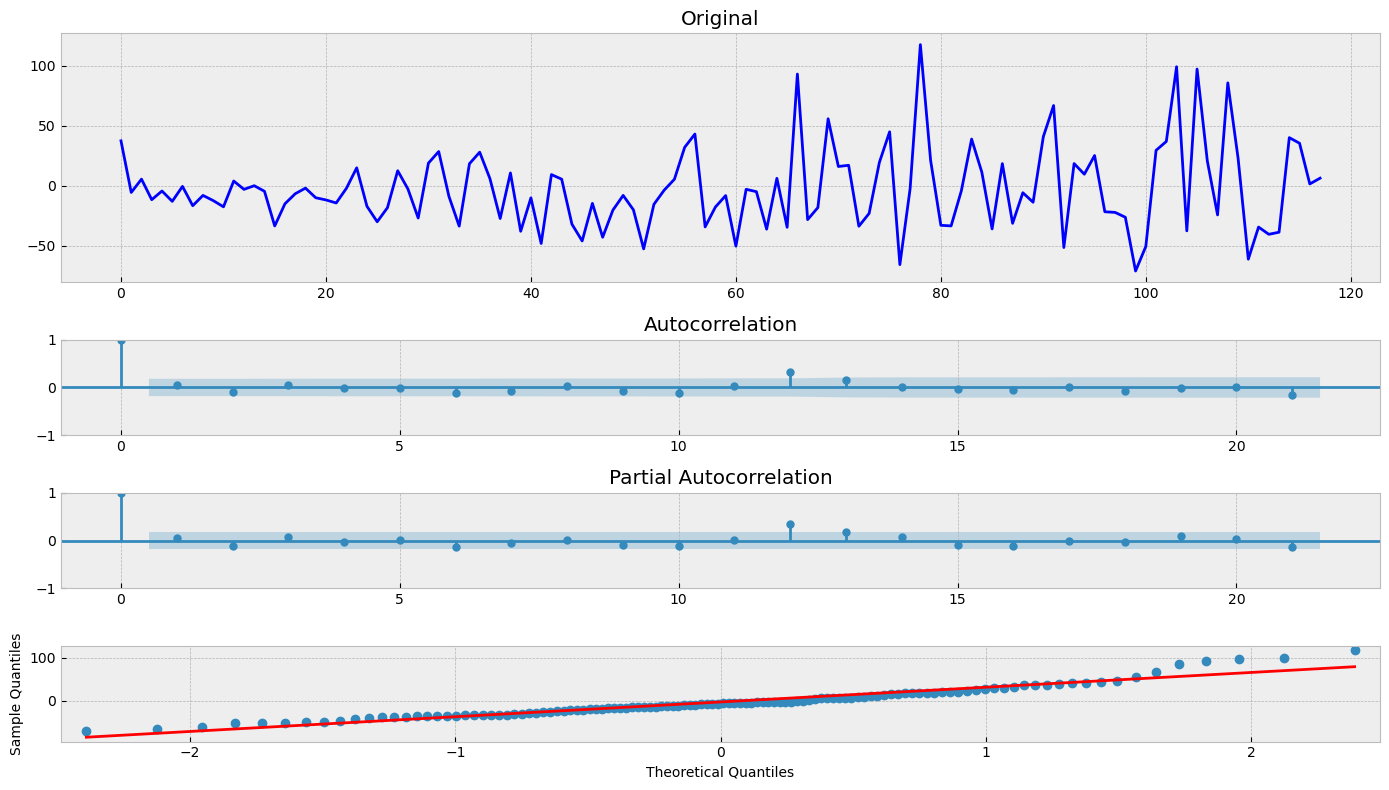

In [76]:
tsplot(model.resid)

# 3. Apply GARCH

In [77]:
series = np.diff(series, 1)
# series = np.diff(series, 12)

In [78]:
series = series.astype(float)

In [79]:
p_, o_, q_ = order

am = arch_model(series, dist='studentst')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -575.055
Distribution:      Standardized Student's t   AIC:                           1160.11
Method:                  Maximum Likelihood   BIC:                           1173.92
                                              No. Observations:                  117
Date:                      Wed, May 15 2024   Df Residuals:                      116
Time:                              17:08:12   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1

Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


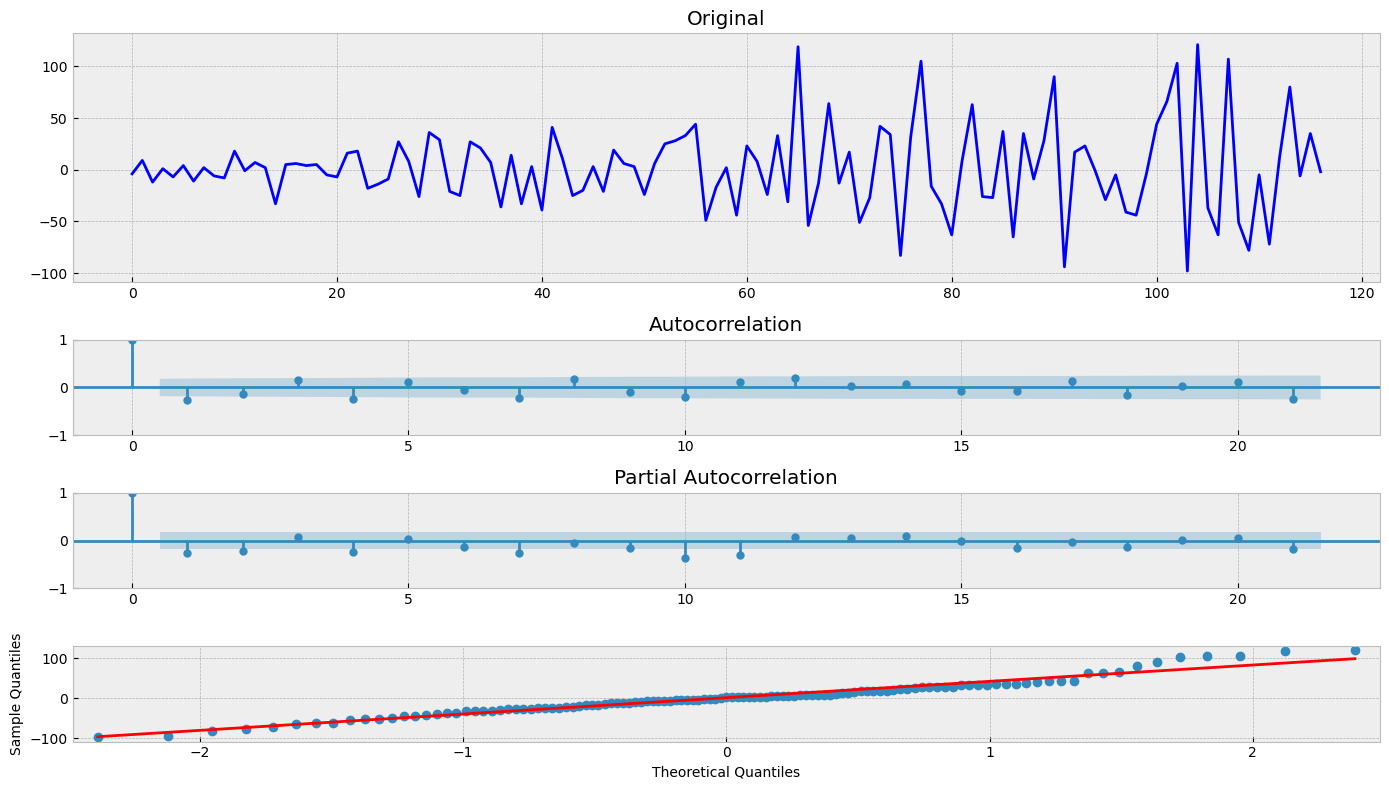

In [80]:
tsplot(res.resid)

# Выводы:
1) Выбрали ТС без сезонности и цикличности, но с варьирующейся дисперсией и трендом
2) Убрали тренд, дифферинцируя по 1
3) Подобрали оптимальные параметры через циклы и алгоритм АРИМА
4) Построили модель GARCH
    - P-value на остаточном ряду получился небольшой => остаточный ряд стационарный => в целом модель фитится неплохо
    - std error у модели вышел довольно большой (ок. 2). Не уверен, ошибка это или нет